# Wave propagation in magnetised plasmas: Faraday Rotation

_Created by Rui Calado and Jorge Vieira, 2018_

In this notebook, we are going to study the propagation of an electromagnetic wave in a magnetised plasma to observe the effect of Faraday rotation. 

Run the next cell once, when you open the notebook, before running anything else.

## Theory

Faraday rotation occurs when a plane-polarized electromagnetic wave propagates along a magnetic field inside a plasma. This wave is called a parallel wave since we have $\mathbf{k}\parallel\mathbf{B}_0$. When this waves traverses a length of plasma, its polarization plane becomes rotated when compared to the initial polarization.

The theory for parallel, plane polarized waves propagating in a magnetised plasma predicts the splitting of the linearly polarized wave into two circularly polarized waves. These waves are called the $R$ and $L$ waves and are, respectively, right-hand and left-hand circularly polarized. The dispersion relations for these two waves are:

$$\frac{c^2k^2}{\omega^2}=\widetilde{n}^2=1-\frac{\omega_p^2/\omega^2}{1-\omega_c/\omega}\quad R\ \mathrm{wave}$$

$$\frac{c^2k^2}{\omega^2}=\widetilde{n}^2=1-\frac{\omega_p^2/\omega^2}{1+\omega_c/\omega}\quad L\ \mathrm{wave}$$

where $\omega_p$ is the plasma frequency and $\omega_c$ the electron cyclotron frequency. For reasons that will soon be clear, we define the cutoff frequencies $\omega_R$ and $\omega_L$:

$$\omega_{R \atop L}=\frac{1}{2}\left ( \sqrt{\omega_c^2+4\omega_p^2} \pm \omega_c \right )$$

Plotting the refraction index $n$ will give us information about the propagation of the waves in this medium.

In [1]:
def ref_ind(wp,wc,w,br=+1):
    return 1-wp**2/(w**2-br*wc*w)

Text(0.5, 1.0, 'Refractive index')

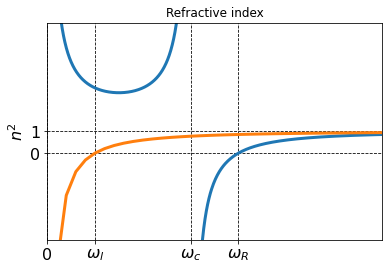

In [2]:
import matplotlib.pyplot as plt
import numpy as np

wC=1.5
wP=1

#Right and left frequencies
wR=(wC+np.sqrt(wC**2+4*wP**2))/2
wL=(np.sqrt(wC**2+4*wP**2)-wC)/2


omega_l=np.linspace(0.1,wC,512,endpoint=False)
omega_r=np.linspace(5,wC,512,endpoint=False)[::-1]

fig=plt.figure()
ax=plt.gca()

ax.plot(omega_l,ref_ind(wP,wC,omega_l), color='C0', linewidth=3)
ax.plot(omega_r,ref_ind(wP,wC,omega_r), color='C0', linewidth=3)

ax.plot(np.linspace(0.1,5),ref_ind(wP,wC,np.linspace(0.1,5),br=-1), color='C1', linewidth=3)

ax.set_xticks([0,wL,wC,wR])
ax.set_xticklabels(["0","$\omega_l$","$\omega_c$","$\omega_R$"],fontsize=16)
ax.set_yticks([0,1])
ax.set_yticklabels(["0","1"],fontsize=16)
ax.set_ylabel("$n^2$",fontsize=16)
ax.grid(c="k",ls="--")
ax.set_xlim(0,3.5)
ax.set_ylim(-4,6)
ax.set_title("Refractive index")

For negative $n^2$ propagation is not possible. Hence, the $L$ wave has one cutoff at $\omega_L$ and propagates as long as $\omega>\omega_L$. For the $R$ wave we have two propagation regions, $0<\omega<\omega_C$ and $\omega>\omega_R$. It has a cutoff at $\omega_R$ and ressonates with the cyclotron motion of the electrons at $\omega_C$. From this plot we see that the $R$ and $L$ waves propagate at different velocities. This leads to a dephasing between the two waves, which in turn leads to a rotation in the polarization plane as they propagate through the plasma.

## Simulations with ZPIC

Below we will simulate waves propagating across magnetised plasmas in the conditions discussed in the *Theory* section. The external magnetic field points in the x-direction, $\mathbf{B}_0=B_0\mathbf{e}_x$. The length of the simulation box is 1500$c/\omega_{p0}$ and it will run for a time $1100\ 1/\omega_{p0}$.

### First case: $\omega=2.3\omega_{p0}$ ; $\omega_c=2.0\omega_{p0}$

In this first case the plasma extends from $x=1000$ to $x=1150$ with a density $n_0$ corresponding to a plasma frequency $\omega_{p0}$. We launch a laser with a frequency of $\omega=2.3\omega_{p0}$ moving in the positive x-direction and polarized with an electric field in the y-direction with peak value $E_{0}=0.023m_ec\omega_{p0}/e$. The laser front is initially at $x=700c/\omega_{p0}$. The amplitude of the external magnetic field corresponds to $\omega_c=2.0\omega_{p0}$.

Run the next two cells to initialize and run the simulation.

In [3]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1d
import numpy as np

# Time step
dt = 0.0499
tmax = 475.0

# Simulation box
nx  = 9500
box = 475

# Diagnostic frequency
ndump = 20

# Background plasma

ppc = 20 # Particles per cell

plasmastart=300.0
plasmaend=450.0
d_prof=em1d.Density( type = "slab", start = plasmastart, end = plasmaend)
electrons = em1d.Species( "electrons", -1.0, ppc, uth=[0.005,0.005,0.005], density = d_prof)

Ex=[]
Ey=[]
Ez=[]
# Diagnostics
def rep( sim ):
    if ( sim.n % ndump == 0 ):
        # All electric field components
        Ex.append(np.array(sim.emf.Ex))
        Ey.append(np.array(sim.emf.Ey))
        Ez.append(np.array(sim.emf.Ez))
        

# Initialize simulation data
sim = em1d.Simulation( nx, box, dt, species=(electrons), report = rep )

# Select open boundary conditions
sim.emf.bc_type = "open"

# Add laser pulse
w0 = 2.3
las=em1d.Laser( start = 175.0, rise=12.5, flat=150, fall=12.5, a0 = 0.01, omega0 = w0, polarization = 0.0 )
#las.omega0=w0
sim.add_laser(las )


B=[2.0, 0.0, 0]

ext = em1d.ExternalField(B_type = 'uniform', B_0 = B)

sim.emf.set_ext_fld( ext )

In [4]:
sim.run( tmax )


Running simulation up to t = 475 ...
n = 9520, t = 475.048
Done.


Next we plot $E_y(t,x)$ and $E_z(t,x)$. Here the color represents the amplitude of the electric field.

(125.0, 475.0)

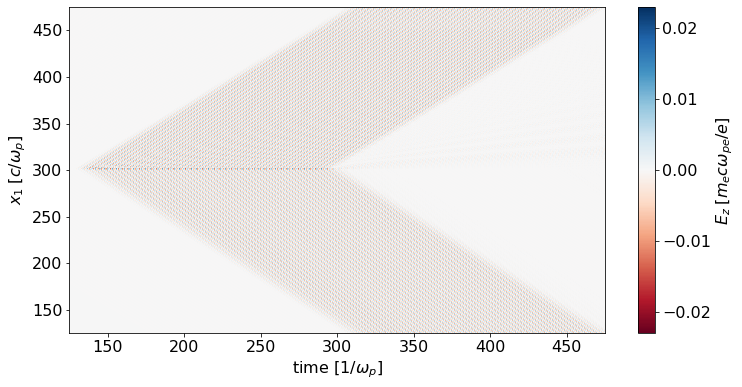

In [5]:
fig=plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
im=plt.imshow(np.transpose(Ez),extent=[0,tmax,0,box],vmin=-0.023,vmax=0.023,cmap="RdBu",origin="lower",aspect="auto",interpolation=None)
cbar=plt.colorbar(im)
cbar.set_label("$E_z\;[m_ec\omega_{pe}/e]$")
plt.xlim(125,tmax)
plt.xlabel("time $[1/\omega_p]$")
plt.ylabel("$x_1\;[c/\omega_p]$")
plt.ylim(125,box)

(125.0, 475.0)

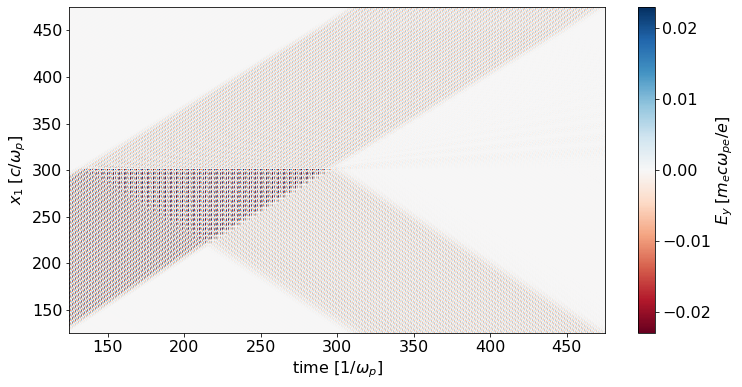

In [6]:
fig=plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
im=plt.imshow(np.transpose(Ey),extent=[0,tmax,0,box],vmin=-0.023,vmax=0.023,cmap="RdBu",origin="lower",aspect="auto",interpolation=None)
cbar=plt.colorbar(im)
cbar.set_label("$E_y\;[m_ec\omega_{pe}/e]$")
plt.xlim(125,tmax)
plt.xlabel("time $[1/\omega_p]$")
plt.ylabel("$x_1\;[c/\omega_p]$")
plt.ylim(125,box)

* Can you explain the behaviour of the wave illustrated by these plots?

Now we plot $E_y(t)$ and $E_z(t)$ at positions before the plasma ($x=740$) and after the plasma ($x=1300$).

Text(0.5, 0, 'x [$c/\\omega_p$]')

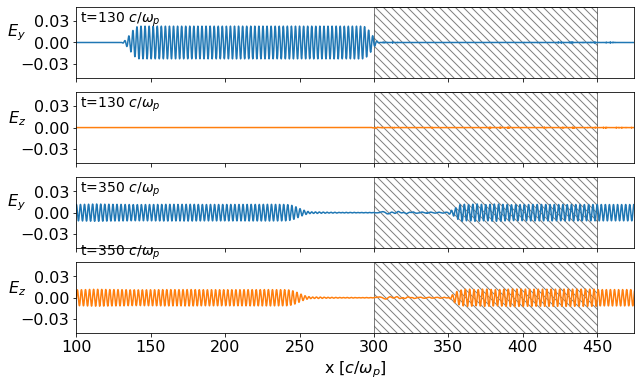

In [7]:
x=np.linspace(0,box,nx)

fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,sharex=True,sharey=True,figsize=(10,6))
ax1.plot(x,Ey[int(130/dt/ndump)])
ax1.add_patch(plt.Rectangle((plasmastart,-0.05),plasmaend-plasmastart,0.1,hatch="\\\\\\",fill=False,alpha=0.5))
ax1.set_title(" t=130 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax1.set_ylabel("$E_y$",rotation=0)

ax2.plot(x,Ez[int(130/dt/ndump)],c="C1")
ax2.add_patch(plt.Rectangle((plasmastart,-0.05),plasmaend-plasmastart,0.1,hatch="\\\\\\",fill=False,alpha=0.5))
ax2.set_title(" t=130 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax2.set_ylabel("$E_z$",rotation=0)

ax3.plot(x,Ey[int(350/dt/ndump)])
ax3.add_patch(plt.Rectangle((plasmastart,-0.05),plasmaend-plasmastart,0.1,hatch="\\\\\\",fill=False,alpha=0.5))
ax3.set_title(" t=350 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax3.set_ylabel("$E_y$",rotation=0)

ax4.plot(x,Ez[int(350/dt/ndump)],c="C1")
ax4.add_patch(plt.Rectangle((plasmastart,-0.05),plasmaend-plasmastart,0.1,hatch="\\\\\\",fill=False,alpha=0.5))
ax4.set_title(" t=350 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax4.set_ylabel("$E_z$",rotation=0)

ax4.set_ylim([-0.05,0.05])
ax4.set_xlim([100,box])
ax4.set_yticks([-0.03,0,0.03])
ax4.set_xlabel("x [$c/\omega_p$]")

* Can you explain these plots?

Finally, we look at the polarization of the electric field by plotting with dots the electric field in different times in the $E_y$ vs. $E_z$ plane. The different colors represent the electric field at three different positions: before the plasma, $x=740$ (blue); inside the plasma, $x=1075$ (red); and after the plasma, $x=1300$ (green).

Text(0.5, 1.0, '$\\sf{E_y\\ vs\\ E_z}$')

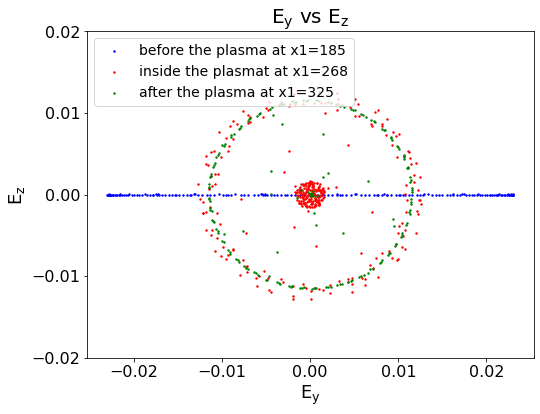

In [8]:
e2plotx502 = np.transpose(Ey)[int(185.0*nx/box)][:int(195/dt/ndump)]
e3plotx502 = np.transpose(Ez)[int(185.0*nx/box)][:int(195/dt/ndump)]
e2plotx548 = np.transpose(Ey)[int(315*nx/box)]
e3plotx548 = np.transpose(Ez)[int(315*nx/box)]
e2plotx596 = np.transpose(Ey)[int(470*nx/box)]
e3plotx596 = np.transpose(Ez)[int(470*nx/box)]

plt.figure(1,figsize=(8,6))
plt.scatter(e2plotx502,e3plotx502,c='b',label='before the plasma at x1=185',s=2)
plt.scatter(e2plotx548,e3plotx548,c='r',label='inside the plasmat at x1=268',s=2)
plt.scatter(e2plotx596,e3plotx596,c='g',label='after the plasma at x1=325',s=2)

plt.xlim=(-0.02,0.02)
plt.ylim=(-0.02,0.02)
plt.xticks(np.arange(-0.02,0.021,0.01))
plt.yticks(np.arange(-0.02,0.021,0.01))

plt.xlabel(r'$\sf{E_y}$',fontsize=18)
plt.ylabel(r'$\sf{E_z}$',fontsize=18)
plt.legend(fontsize=14)
plt.title(r'$\sf{E_y\ vs\ E_z}$',fontsize=20)

* Can you explain this polarization signature?

### Second case: $\omega=5.0\omega_{p0}$ ; $\omega_c=0.5\omega_{p0}$

In the second case the plasma extends from $x=1000$ to $x=1150$ with a density $n_0$ corresponding to a plasma frequency $\omega_{p0}$. We launch a laser with a frequency of $\omega=5.0\omega_{p0}$ moving in the positive x-direction and polarized with an electric field in the y-direction with peak value $E_{0}=0.05m_ec\omega_{p0}/e$. The laser front is initially at $x=700c/\omega_{p0}$. The amplitude of the external magnetic field corresponds to $\omega_c=0.5\omega_{p0}$.

Run the next two cells to initialize and run the simulation.

In [9]:
d_prof=em1d.Density( type = "slab", start = plasmastart, end = plasmaend)
electrons = em1d.Species( "electrons", -1.0, ppc, uth=[0.005,0.005,0.005], density = d_prof)

Ex=[]
Ey=[]
Ez=[]
# Diagnostics
def rep( sim ):
    if ( sim.n % ndump == 0 ):
        
        # All electric field components
        Ex.append(np.array(sim.emf.Ex))
        Ey.append(np.array(sim.emf.Ey))
        Ez.append(np.array(sim.emf.Ez))
        

# Initialize simulation data
sim = em1d.Simulation( nx, box, dt, species=(electrons), report = rep )

# Select open boundary conditions
sim.emf.bc_type = "open"

# Add laser pulse
w0 = 5
#sim.add_laser( em1d.Laser( start = 700.0, rise=50, flat=600, fall=50, a0 = 0.01, omega0 = w0, polarization = 0.0 ))
sim.add_laser( em1d.Laser( start = 175.0, rise=12.5, flat=150, fall=12.5, a0 = 0.01, omega0 = w0, polarization = 0.0 ))
B=[0.5, 0.0, 0.0]
ext = em1d.ExternalField(B_type = 'uniform', B_0 = B)

sim.emf.set_ext_fld( ext )

In [10]:
sim.run( tmax )


Running simulation up to t = 475 ...
n = 9520, t = 475.048
Done.


Once again, we plot $E_y(t,x)$ and $E_z(t,x)$.

(270.0, 475.0)

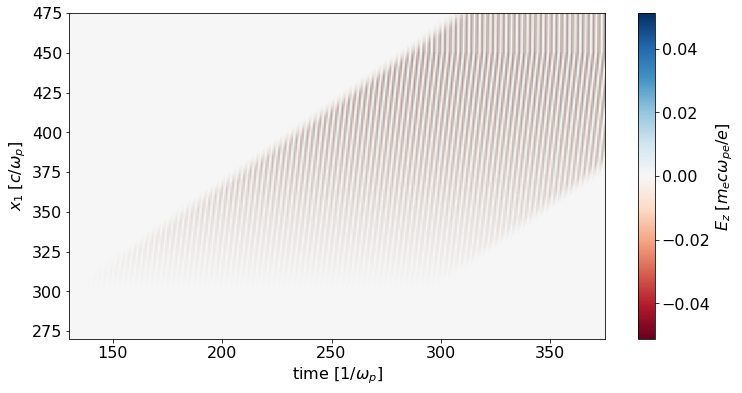

In [11]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
im=plt.imshow(np.transpose(Ez),extent=[0,tmax,0,box],cmap="RdBu",origin="lower",aspect="auto",interpolation=None)
cbar=plt.colorbar(im)
ax=plt.gca()
cbar.set_label("$E_z\;[m_ec\omega_{pe}/e]$")
ax.set_xlim(130,375)
ax.set_xlabel("time $[1/\omega_p]$")
ax.set_ylabel("$x_1\;[c/\omega_p]$")
ax.set_ylim(270,475)

(250.0, 475.0)

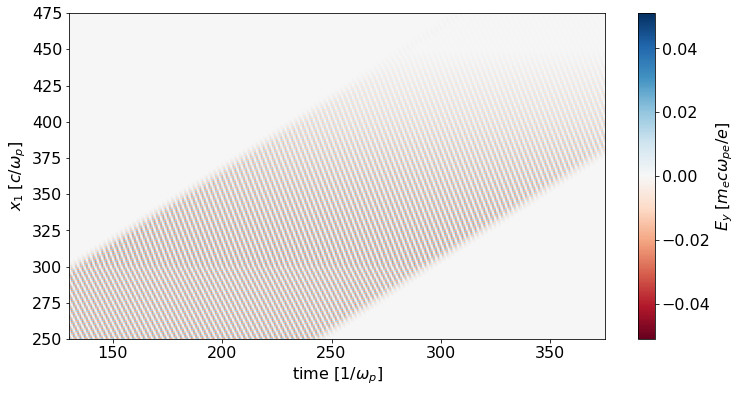

In [12]:
fig=plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
ax=plt.gca()
im=plt.imshow(np.transpose(Ey),extent=[0,tmax,0,box],cmap="RdBu",origin="lower",aspect="auto",interpolation=None)
cbar=plt.colorbar(im)
cbar.set_label("$E_y\;[m_ec\omega_{pe}/e]$")
ax.set_xlim(130,375)
ax.set_xlabel("time $[1/\omega_p]$")
ax.set_ylabel("$x_1\;[c/\omega_p]$")
ax.set_ylim(250,475)

* Can you explain the behaviour of the wave illustrated by these plots?
* Why is the behaviour different when compared to the first case?

Now we plot $E_y(t)$ and $E_z(t)$ at positions before the plasma ($x=740$) and after the plasma ($x=1300$).

Text(0.5, 0, 'x [$c/\\omega_p$]')

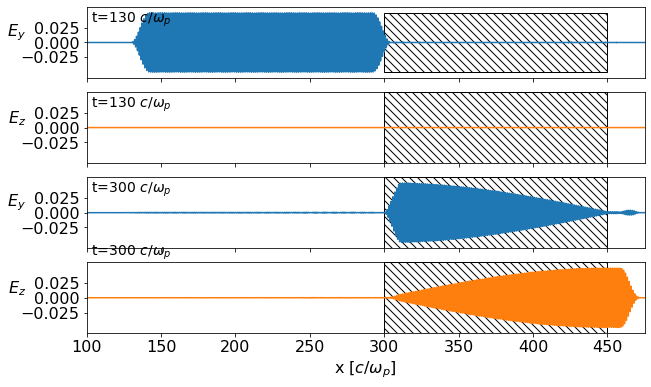

In [13]:
x=np.linspace(0,box,nx)

fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,sharex=True,sharey=True,figsize=(10,6))
ax1.plot(x,Ey[int(130/dt/ndump)])
ax1.add_patch(plt.Rectangle((plasmastart,-0.05),plasmaend-plasmastart,0.1,hatch="\\\\\\",fill=False))
ax1.set_title(" t=130 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax1.set_ylabel("$E_y$",rotation=0)

ax2.plot(x,Ez[int(130/dt/ndump)],c="C1")
ax2.add_patch(plt.Rectangle((plasmastart,-0.06),plasmaend-plasmastart,0.12,hatch="\\\\\\",fill=False))
ax2.set_title(" t=130 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax2.set_ylabel("$E_z$",rotation=0)

ax3.plot(x,Ey[int(300/dt/ndump)])
ax3.add_patch(plt.Rectangle((plasmastart,-0.06),plasmaend-plasmastart,0.12,hatch="\\\\\\",fill=False))
ax3.set_title(" t=300 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax3.set_ylabel("$E_y$",rotation=0)

ax4.plot(x,Ez[int(300/dt/ndump)],c="C1")
ax4.add_patch(plt.Rectangle((plasmastart,-0.06),plasmaend-plasmastart,0.12,hatch="\\\\\\",fill=False))
ax4.set_title(" t=300 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax4.set_ylabel("$E_z$",rotation=0)

ax4.set_ylim([-0.06,0.06])
ax4.set_xlim([100,475])
ax4.set_yticks([-0.025,0,0.025])
ax4.set_xlabel("x [$c/\omega_p$]")

* Can you explain these plots?
* What are the differences between this case and the previous one?

Finally, we look at the polarization of the electric field by plotting with dots the electric field in different times in the $E_y$ vs. $E_z$ plane. The different colors represent the electric field at three different positions: before the plasma, $x=740$ (blue); inside the plasma, $x=1075$ (red); and after the plasma, $x=1300$ (green).

Text(0.5, 1.0, '$\\sf{E_y\\ vs\\ E_z}$')

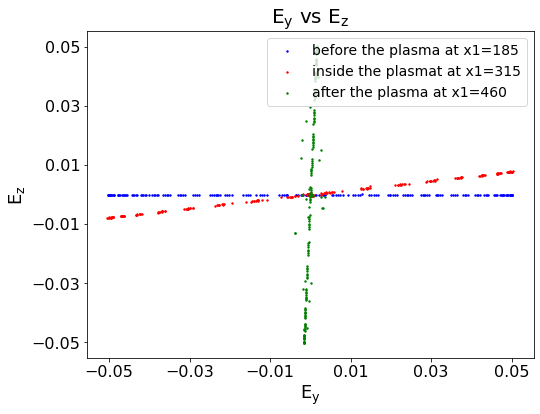

In [14]:
e2plotx502 = np.transpose(Ey)[int(185.0*nx/box)][:int(195/dt/ndump)]
e3plotx502 = np.transpose(Ez)[int(185.0*nx/box)][:int(195/dt/ndump)]
e2plotx548 = np.transpose(Ey)[int(315*nx/box)]
e3plotx548 = np.transpose(Ez)[int(315*nx/box)]
e2plotx596 = np.transpose(Ey)[int(460*nx/box)]
e3plotx596 = np.transpose(Ez)[int(460*nx/box)]

plt.figure(1,figsize=(8,6))
plt.scatter(e2plotx502,e3plotx502,c='b',label='before the plasma at x1=185',s=2)
plt.scatter(e2plotx548,e3plotx548,c='r',label='inside the plasmat at x1=315',s=2)
plt.scatter(e2plotx596,e3plotx596,c='g',label='after the plasma at x1=460',s=2)

plt.xlim=(-0.02,0.02)
plt.ylim=(-0.02,0.02)
plt.xticks(np.arange(-0.05,0.051,0.02))
plt.yticks(np.arange(-0.05,0.051,0.02))

plt.xlabel(r'$\sf{E_y}$',fontsize=18)
plt.ylabel(r'$\sf{E_z}$',fontsize=18)
plt.legend(fontsize=14)
plt.title(r'$\sf{E_y\ vs\ E_z}$',fontsize=20)

* Can you explain this polarization signature?
* What is the rotation in the polarization?

### Third case: $\omega=2.97\omega_{p0}$ ; $\omega_c=0.5\omega_{p0}$

In the second case the plasma extends from $x=1000$ to $x=1150$ with a density $n_0$ corresponding to a plasma frequency $\omega_{p0}$. We launch a laser with a frequency of $\omega=2.97\omega_{p0}$ moving in the positive x-direction and polarized with an electric field in the y-direction with peak value $E_{0}=0.0297m_ec\omega_{p0}/e$. The laser front is initially at $x=700c/\omega_{p0}$. The amplitude of the external magnetic field corresponds to $\omega_c=0.5\omega_{p0}$.

Run the next two cells to initialize and run the simulation.

In [15]:
d_prof=em1d.Density( type = "slab", start = plasmastart, end = plasmaend)
electrons = em1d.Species( "electrons", -1.0, ppc, uth=[0.005,0.005,0.005], density = d_prof)

Ex=[]
Ey=[]
Ez=[]
# Diagnostics
def rep( sim ):
    if ( sim.n % ndump == 0 ):
        
        # All electric field components
        Ex.append(np.array(sim.emf.Ex))
        Ey.append(np.array(sim.emf.Ey))
        Ez.append(np.array(sim.emf.Ez))
        

# Initialize simulation data
sim = em1d.Simulation( nx, box, dt, species=(electrons), report = rep )

# Select open boundary conditions
sim.emf.bc_type = "open"

# Add laser pulse
w0 = 2.97
#sim.add_laser( em1d.Laser( start = 700.0, rise=50, flat=600, fall=50, a0 = 0.01, omega0 = w0, polarization = 0.0 ))
sim.add_laser( em1d.Laser( start = 175.0, rise=12.5, flat=150, fall=12.5, a0 = 0.01, omega0 = w0, polarization = 0.0 ))
B=[0.5, 0.0, 0.0]
ext = em1d.ExternalField(B_type = 'uniform', B_0 = B)

sim.emf.set_ext_fld( ext )

In [16]:
sim.run( tmax )


Running simulation up to t = 475 ...
n = 9520, t = 475.048
Done.


Once again, we plot $E_y(t,x)$ and $E_z(t,x)$.

(250.0, 475.0)

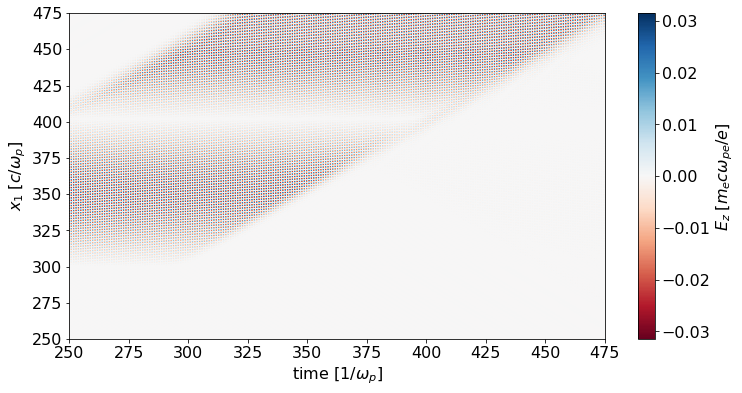

In [17]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
im=plt.imshow(np.transpose(Ez),extent=[0,tmax,0,box],cmap="RdBu",origin="lower",aspect="auto",interpolation=None)
cbar=plt.colorbar(im)
ax=plt.gca()
cbar.set_label("$E_z\;[m_ec\omega_{pe}/e]$")
ax.set_xlim(250,tmax)
ax.set_xlabel("time $[1/\omega_p]$")
ax.set_ylabel("$x_1\;[c/\omega_p]$")
ax.set_ylim(250,box)

(250.0, 475.0)

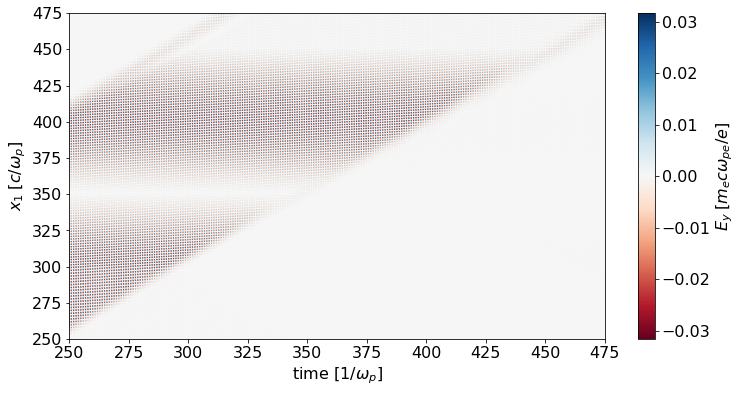

In [18]:
fig=plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
ax=plt.gca()
im=plt.imshow(np.transpose(Ey),extent=[0,tmax,0,box],cmap="RdBu",origin="lower",aspect="auto",interpolation=None)
cbar=plt.colorbar(im)
cbar.set_label("$E_y\;[m_ec\omega_{pe}/e]$")
ax.set_xlim(250,tmax)
ax.set_xlabel("time $[1/\omega_p]$")
ax.set_ylabel("$x_1\;[c/\omega_p]$")
ax.set_ylim(250,box)

* Can you explain the behaviour of the wave illustrated by these plots?
* What is different when compared to the second case?

Now we plot $E_y(t)$ and $E_z(t)$ at positions before the plasma ($x=740$) and after the plasma ($x=1300$).

Text(0.5, 0, 'x [$c/\\omega_p$]')

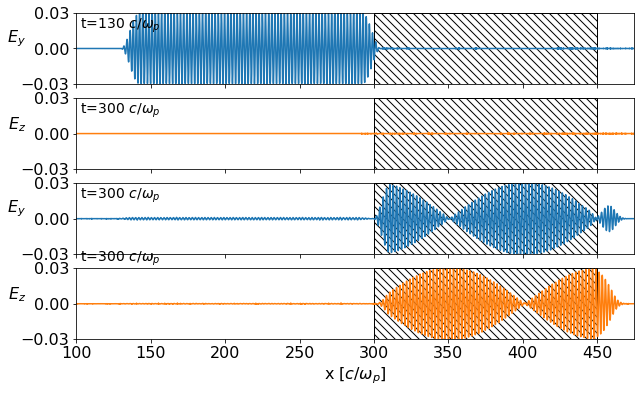

In [19]:
x=np.linspace(0,box,nx)

fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,sharex=True,sharey=True,figsize=(10,6))
ax1.plot(x,Ey[int(130/dt/ndump)])
ax1.add_patch(plt.Rectangle((plasmastart,-0.03),plasmaend-plasmastart,0.06,hatch="\\\\\\",fill=False))
ax1.set_title(" t=130 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax1.set_ylabel("$E_y$",rotation=0)

ax2.plot(x,Ez[int(130/dt/ndump)],c="C1")
ax2.add_patch(plt.Rectangle((plasmastart,-0.03),plasmaend-plasmastart,0.06,hatch="\\\\\\",fill=False))
ax2.set_title(" t=300 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax2.set_ylabel("$E_z$",rotation=0)

ax3.plot(x,Ey[int(300/dt/ndump)])
ax3.add_patch(plt.Rectangle((plasmastart,-0.03),plasmaend-plasmastart,0.06,hatch="\\\\\\",fill=False))
ax3.set_title(" t=300 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax3.set_ylabel("$E_y$",rotation=0)

ax4.plot(x,Ez[int(300/dt/ndump)],c="C1")
ax4.add_patch(plt.Rectangle((plasmastart,-0.03),plasmaend-plasmastart,0.06,hatch="\\\\\\",fill=False))
ax4.set_title(" t=300 $c/\omega_p$",loc="left",pad=-15,fontsize=14)
ax4.set_ylabel("$E_z$",rotation=0)

ax4.set_ylim([-0.03,0.03])
ax4.set_xlim([100,box])
ax4.set_yticks([-0.03,0,0.03])
ax4.set_xlabel("x [$c/\omega_p$]")

* Can you explain these plots?

Finally, we look at the polarization of the electric field by plotting with dots the electric field in different times in the $E_y$ vs. $E_z$ plane. The different colors represent the electric field at three different positions: before the plasma, $x=740$ (blue); inside the plasma, $x=1075$ (red); and after the plasma, $x=1300$ (green).

Text(0.5, 1.0, '$\\sf{E_y\\ vs\\ E_z}$')

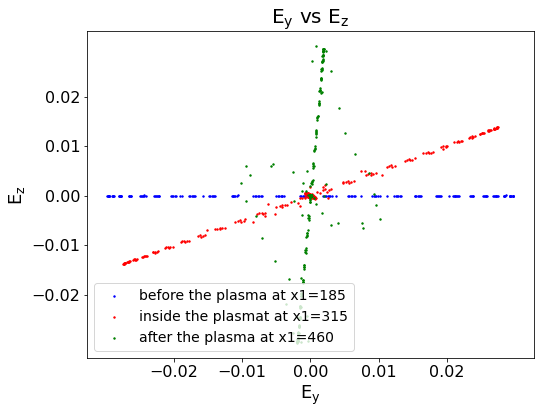

In [20]:
e2plotx502 = np.transpose(Ey)[int(185.0*nx/box)][:int(195/dt/ndump)]
e3plotx502 = np.transpose(Ez)[int(185.0*nx/box)][:int(195/dt/ndump)]
e2plotx548 = np.transpose(Ey)[int(315*nx/box)]
e3plotx548 = np.transpose(Ez)[int(315*nx/box)]
e2plotx596 = np.transpose(Ey)[int(460*nx/box)]
e3plotx596 = np.transpose(Ez)[int(460*nx/box)]

plt.figure(1,figsize=(8,6))
plt.scatter(e2plotx502,e3plotx502,c='b',label='before the plasma at x1=185',s=2)
plt.scatter(e2plotx548,e3plotx548,c='r',label='inside the plasmat at x1=315',s=2)
plt.scatter(e2plotx596,e3plotx596,c='g',label='after the plasma at x1=460',s=2)

plt.xlim=(-0.02,0.02)
plt.ylim=(-0.02,0.02)
plt.xticks(np.arange(-0.02,0.021,0.01))
plt.yticks(np.arange(-0.02,0.021,0.01))

plt.xlabel(r'$\sf{E_y}$',fontsize=18)
plt.ylabel(r'$\sf{E_z}$',fontsize=18)
plt.legend(fontsize=14)
plt.title(r'$\sf{E_y\ vs\ E_z}$',fontsize=20)

* Can you explain this polarization signature?
* What is the rotation in the polarization? How can you tell?